In [ ]:
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


In [ ]:
# load the csv file
print('loading the data...')
data=pd.read_csv('data/driving_log.csv')
samples =np.asarray(data)
print(samples)
print("Data Load")

loading the data...
[['IMG/center_2016_12_01_13_30_48_287.jpg'
  ' IMG/left_2016_12_01_13_30_48_287.jpg'
  ' IMG/right_2016_12_01_13_30_48_287.jpg' ... 0.0 0.0 22.14829]
 ['IMG/center_2016_12_01_13_30_48_404.jpg'
  ' IMG/left_2016_12_01_13_30_48_404.jpg'
  ' IMG/right_2016_12_01_13_30_48_404.jpg' ... 0.0 0.0 21.87963]
 ['IMG/center_2016_12_01_13_31_12_937.jpg'
  ' IMG/left_2016_12_01_13_31_12_937.jpg'
  ' IMG/right_2016_12_01_13_31_12_937.jpg' ... 0.0 0.0 1.453011]
 ...
 ['IMG/center_2016_12_01_13_46_38_846.jpg'
  ' IMG/left_2016_12_01_13_46_38_846.jpg'
  ' IMG/right_2016_12_01_13_46_38_846.jpg' ... 0.0 0.0 1.388364]
 ['IMG/center_2016_12_01_13_46_38_922.jpg'
  ' IMG/left_2016_12_01_13_46_38_922.jpg'
  ' IMG/right_2016_12_01_13_46_38_922.jpg' ... 0.0 0.0 1.377208]
 ['IMG/center_2016_12_01_13_46_38_947.jpg'
  ' IMG/left_2016_12_01_13_46_38_947.jpg'
  ' IMG/right_2016_12_01_13_46_38_947.jpg' ... 0.0 0.0 1.374433]]
Data Load


In [ ]:
# splitting the dataset to train and validation set using sklearn.
# use 80% for training and 20% for validation

train_samples, validation_samples = train_test_split(samples ,test_size=0.2)

print("Number of sample lines ",len(samples))
print("Number of train lines ",len(train_samples))
print("Number of validation lines ",len(validation_samples))

Number of sample lines  8036
Number of train lines  6428
Number of validation lines  1608


In [ ]:
from sklearn.utils import shuffle
import tensorflow as tf


In [ ]:
# Parameters for training data augmentation
CORRECTION = 0.2
# Network hyper parameter configuration
EPOCHS=2
BATCH_SIZE=32

In [ ]:

# generator
def generator(samples, batch_size):
    num_samples = len(samples)
   
    while 1: 
        #shuffling images
        shuffle(samples) 
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                    #we are taking 3 images, first one is center, second is left and third is right
                    for i in range(0,3): 
                        source_path = batch_sample[i]
                        file_name = source_path.split('/')[-1]
                        current_path = './data/IMG/' + file_name
                        #since CV2 reads an image in BGR we need to convert it to RGB since in drive.py it is RGB
                        center_image = cv2.cvtColor(cv2.imread(current_path), cv2.COLOR_BGR2RGB) 
                        #getting the steering angle measurement
                        center_angle = float(batch_sample[3]) 
                        images.append(center_image)
                        
                        # introducing correction for left and right images
                        # if image is in left we increase the steering angle by 0.2
                        # if image is in right we decrease the steering angle by 0.2
                        
                        if(i==0):
                            angles.append(center_angle)
                        elif(i==1):
                            angles.append(center_angle+CORRECTION)
                        elif(i==2):
                            angles.append(center_angle-CORRECTION)
                        
                        # data Augmentation .
                        # We take the image and  flip it around y-axis and negate the measurement (taking the opposite sign of the steering measurement )
                        
                        images.append(cv2.flip(center_image,1))
                        
                        if(i==0):
                            angles.append(center_angle*-1)
                        elif(i==1):
                            angles.append((center_angle+CORRECTION)*-1)
                        elif(i==2):
                            angles.append((center_angle-CORRECTION)*-1)
                        
                        
        
            X_train = np.array(images)
            y_train = np.array(angles)
            
            # here we do not hold the values of X_train and y_train instead we yield the values which means we hold until the generator is running
            yield shuffle(X_train, y_train)
            
            
print("generator defined.")

generator defined.


In [ ]:
# compile and train the model using the generator function
train_generator = generator(train_samples, BATCH_SIZE)
validation_generator = generator(validation_samples, BATCH_SIZE)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout , Conv2D
from keras.layers import Lambda, Cropping2D

C:\Users\monce\AppData\Local\Temp\ipykernel_25020\1228352011.py:79: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_generator, steps_per_epoch= len(train_samples), validation_data=validation_generator,   validation_steps=len(validation_samples), epochs=EPOCHS, verbose=1)


Epoch 1/2
6428/6428 [==============================] - 3300s 513ms/step - loss: 0.0078 - val_loss: 0.0146
Epoch 2/2
6428/6428 [==============================] - 3254s 506ms/step - loss: 0.0017 - val_loss: 0.0139
Done! Model Saved!
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 160, 320, 3)       0         
                                                                 
 cropping2d_6 (Cropping2D)   (None, 65, 320, 3)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 31, 158, 24)       1824      
                                                                 
 activation_54 (Activation)  (None, 31, 158, 24)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 77, 36)        21636     
                     

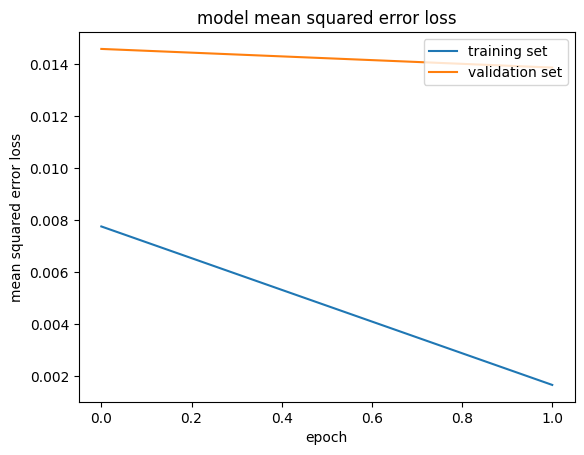

In [ ]:
CROP_TOP = 70
CROP_BOTTOM = 25


model = Sequential()

'''
Lambda Layer allows to specify the operation  ( normalization ) 
to be applied as a function that operate on each image as it passes through the layer

'''
# Preprocess incoming data ( normalization )
model.add(Lambda(lambda x: (x / 128.0) - 1,input_shape=(160,320,3)))

'''
the Cropping Layer crop the input images by 
    - 70 rows pixels from the top image
    - 25 rows pixels from the bottom image
    - 0 Columns pixels from the left of the  image
    - 0 Columns pixels from the right of the image

'''
# crops at top and bottom, ROI ( output ) shape = (65, 320, 3)
model.add(Cropping2D(cropping=((CROP_TOP,CROP_BOTTOM), (0,0))))

# layer 1- Convolution layer with 24 filters , a 5x5 kernel, stride= 2x2
model.add(Conv2D( filters = 24 , kernel_size = (5,5) , strides=(2,2) ))
# Relu Activation Function 
model.add(Activation('relu'))

# layer 2- Convolution layer with 36 filters , a 5x5 kernel, stride= 2x2
model.add(Conv2D( filters = 36 , kernel_size = (5,5) , strides=(2,2) ))
model.add(Activation('relu'))

# layer 3- Convolution layer with 48 filters , a 5x5 kernel, stride= 2x2
model.add(Conv2D( filters = 48 , kernel_size = (5,5) , strides=(2,2) ))
model.add(Activation('relu'))

# layer 4- Convolution layer with 64 filters , a 3x3 kernel, stride= 1x1
model.add(Conv2D( filters = 64 , kernel_size = (3,3) ))
model.add(Activation('relu'))

# layer 5- Convolution layer with 64 filters , a 3x3 kernel, stride= 1x1
model.add(Conv2D( filters = 64 , kernel_size = (3,3) ))
model.add(Activation('relu'))

# flatten image from 2D to side by side
model.add(Flatten())

# layer 6- fully connected layer 1
model.add(Dense(1164))
model.add(Activation('relu'))

# layer 7- fully connected layer 1
model.add(Dense(100))
model.add(Activation('relu'))

# Adding a dropout layer to avoid overfitting. Here we are have given the dropout rate as 25% after first fully connected layer
model.add(Dropout(0.25))

# layer 8- fully connected layer 2
model.add(Dense(50))
model.add(Activation('relu'))


# layer 9- fully connected layer 3
model.add(Dense(10))
model.add(Activation('relu'))

# layer 10- fully connected layer 4
model.add(Dense(1)) 

# train the model

# using mean squared error loss function & adam optimizer 
model.compile(optimizer='adam', loss='mse')

#fit generator is used here as the number of images are generated by the generator
results = model.fit_generator(train_generator, steps_per_epoch= len(train_samples), validation_data=validation_generator,   validation_steps=len(validation_samples), epochs=EPOCHS, verbose=1)

#saving model
model.save('../Behavioral_Cloning_Project/model2.h5')
print('Done! Model Saved!')

# keras method to print the model summary
model.summary()

### print the keys contained in the history object
print(results.history.keys())

### plot the training and validation loss for each epoch
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.savefig("../Behavioral_Cloning_Project/learning_curve.png")
